# Project 1

随机生成 10000 个带有 50 个变量的 3CNF 公式，使用 MINISAT 检查它们是否可满足，展示相变效应。

## MINISAT Setup

Environment:

- macOS 13.3.1 (Apple M1)
- Apple Clang 14.0.3
- CMake 3.26.3

Steps:

1. Clone MINISAT from https://github.com/niklasso/minisat
2. Fix syntax and link errors based on https://github.com/niklasso/minisat/issues/16
3. Compile MINISAT in `build` directory with `cmake .. && make`

## Python Wrapper

Load Python libraries:

In [2]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Global configuration:

In [3]:
MINISAT_PATH = './minisat/build/minisat'  # Path to minisat executable
N = 10000  # Number of 3CNFs
V = 50  # Number of variables
C2V_MIN = 1.5  # Minimum ratio of clauses to variables
C2V_MAX = 8.5  # Maximum ratio of clauses to variables

Utility functions for:
- Generating, printing and saving 3CNFs in [DIMACS](https://www.domagoj-babic.com/uploads/ResearchProjects/Spear/dimacs-cnf.pdf) format
- Calling MINISAT to check satisfiability of CNFs

In [4]:
def generate_3cnf(v, c):
    '''
    Generate 3CNF in DIMACS format.
    v: number of variables
    c: number of clauses
    return: np.array of shape (c, 3) containing the clauses
    example: generate_3cnf(3, 2) -> [[1, 2, 3], [-1, -2, -3]]
    '''

    cnf = np.zeros(c * 3, dtype=int)
    cnf[:v] = np.arange(1, v + 1)
    cnf[v:] = np.random.randint(1, v + 1, size=c * 3 - v)
    np.random.shuffle(cnf)
    cnf = cnf.reshape(c, 3)
    cnf = np.where(np.random.randint(0, 2, size=cnf.shape), cnf, -cnf)

    return cnf


def print_cnf(cnf):
    c, _ = cnf.shape
    print(f'p cnf {cnf.max()} {c}\n')
    for clause in cnf:
        print(' '.join(map(str, clause)), '0')


def save_cnf(cnf, path):
    with open(path, 'w') as f:
        c, _ = cnf.shape
        f.write(f'p cnf {cnf.max()} {c}\n')
        for clause in cnf:
            f.write(' '.join(map(str, clause)) + ' 0\n')


def solve_sat(cnf):
    '''
    Solve SAT problem using minisat.
    cnf: np.array of shape (c, 3) containing the clauses
    return: (sat, ms) where sat is True if the problem is satisfiable and ms is the time in milliseconds
    '''
    save_cnf(cnf, 'tmp.cnf')
    try:
        res = subprocess.check_output(
            [MINISAT_PATH, 'tmp.cnf'], universal_newlines=True
        )
    except subprocess.CalledProcessError as e:
        res = e.output
    sat = not res.endswith('UNSATISFIABLE\n')
    # ms = float(res.split('\n')[-4].split()[-2]) * 1000
    calls = int(res.split('\n')[-7].split()[2])
    os.remove('tmp.cnf')
    return sat, calls

## Phase Transition of Probability

Generate 3CNFs with different clause-to-variable ratios and check satisfiability:

In [5]:
df = pd.DataFrame(
    data=np.zeros((N, 2), dtype=int), columns=['c2v', 'satisfiable']
)


def func(row):
    c = np.random.randint(V * C2V_MIN, V * C2V_MAX)
    cnf = generate_3cnf(V, c)
    row['c2v'] = c / V
    row['satisfiable'], _ = solve_sat(cnf)
    return row


df = df.apply(func, axis=1)
df['c2v_bin'] = pd.cut(df['c2v'], bins=np.linspace(C2V_MIN, C2V_MAX, 20))
df['c2v_bin'] = df['c2v_bin'].apply(lambda x: x.mid).astype(float)
df

,c2v,satisfiable,c2v_bin
0,4.28,False,4.2630
1,5.82,False,5.7370
2,4.76,False,4.6315
3,5.72,False,5.7370
4,5.90,False,5.7370
...,...,...,...
9995,8.18,False,8.3160
9996,6.64,False,6.4735
9997,7.84,False,7.9475
9998,6.72,False,6.8420


Plot the results:

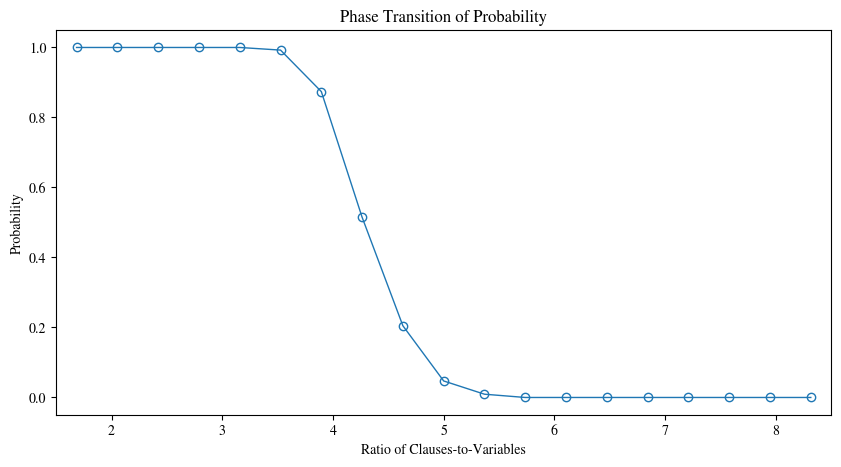

In [6]:
ax = (
    df.groupby('c2v_bin')
    .mean()
    .plot.line(y='satisfiable', legend=False, figsize=(10, 5), marker='o')
)
ax.set_xlim(C2V_MIN, C2V_MAX)
ax.set_xlabel('Ratio of Clauses-to-Variables')
ax.set_ylabel('Probability')
ax.set_title('Phase Transition of Probability')
plt.show()

According to our empirical results, the satisfiability of 3CNFs changes from almost always satisfiable to almost always unsatisfiable when the clause-to-variable ratio increases from 3.5 to 5. The phase transition happens at around 4.2, where the probability of satisfiability is 0.5. The results are consistent with the conjectured phase transition point of $\sqrt{10} + 1\approx 4.17$.

## Phase Transition of Propagation Calls

Generate 3CNFs with `V in [20, 40, 50]` and record the number of `propogation`:

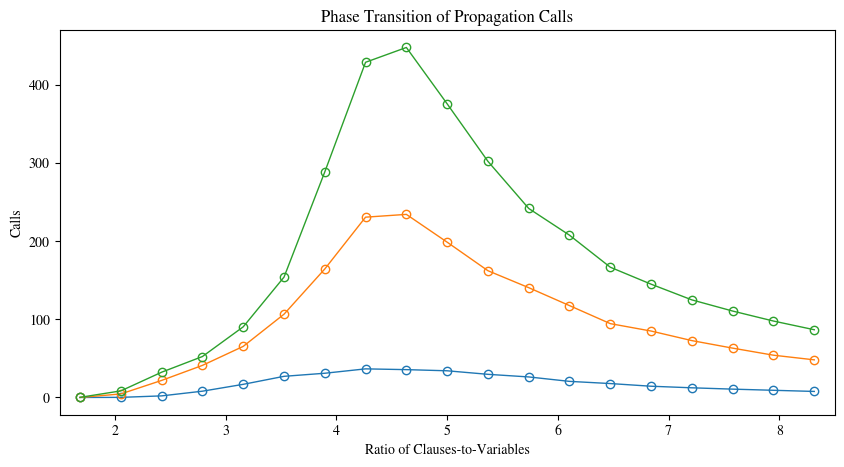

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

for V in [20, 40, 50]:
    df = pd.DataFrame(
        data=np.zeros((N, 3), dtype=int), columns=['c2v', 'satisfiable', 'calls']
    )

    def func(row):
        c = np.random.randint(V * C2V_MIN, V * C2V_MAX)
        cnf = generate_3cnf(V, c)
        row['c2v'] = c / V
        row['satisfiable'], row['calls'] = solve_sat(cnf)
        return row

    df = df.apply(func, axis=1)
    df = df[df['calls'] < 10000]
    df['c2v_bin'] = pd.cut(df['c2v'], bins=np.linspace(C2V_MIN, C2V_MAX, 20))
    df['c2v_bin'] = df['c2v_bin'].apply(lambda x: x.mid).astype(float)

    ax.plot(
        df.groupby('c2v_bin').mean()['calls'],
        label=f'{V} variables',
        marker='o',
    )

ax.set_xlim(C2V_MIN, C2V_MAX)
ax.set_xlabel('Ratio of Clauses-to-Variables')
ax.set_ylabel('Calls')
ax.set_title('Phase Transition of Propagation Calls')
plt.show()